In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Global config variables
num_steps = 5 # number of truncated backprop steps ('n' in the discussion above)
batch_size = 200
num_classes = 2
state_size = 4 #size of the hidden unit of a RNN cell
learning_rate = 0.1

The Basic RNN model:

$S_t = tanh ( W . [X_t, S_{t-1}] + b_s)$

$O_t = \sigma (U . S_t + b_o)$

where

$X_t \in R^{n}$ is the input

$S_t \in R^{h}$ is the internal (memory) state

$O_t \in R^{m}$ is the output

$W \in W^{h \times (n + h)}$

$U \in W^{m \times h}$


## Generate some sample time series data

In [11]:
def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)

    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    # further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps
    print "batch_partition_length={}, epoch_size={}".format(batch_partition_length,epoch_size)
    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        yield (x, y)

def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)

## Constructing RNN with the LSTM architecture

In [4]:
x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

# Turn our x placeholder into a list of one-hot tensors:
# rnn_inputs is a list of num_steps tensors with shape [batch_size, num_classes]
x_one_hot = tf.one_hot(x, num_classes)
rnn_inputs = tf.unstack(x_one_hot, axis=1)

In [5]:
"""
Adding rnn_cells to graph

This is a simplified version of the "static_rnn" function from Tensorflow's api. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/core_rnn.py#L41
Note: In practice, using "dynamic_rnn" is a better choice that the "static_rnn":
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn.py#L390
"""
cell = tf.contrib.rnn.BasicRNNCell(state_size)
rnn_outputs, final_state = tf.contrib.rnn.static_rnn(cell, rnn_inputs, initial_state=init_state)

"""
loss and training step

Losses is similar to the "sequence_loss"
function from Tensorflow's API, except that here we are using a list of 2D tensors, instead of a 3D tensor. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/seq2seq/python/ops/loss.py#L30
"""

with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]

# Turn our y placeholder into a list of labels
y_as_list = tf.unstack(y, num=num_steps, axis=1)


In [15]:
#losses and train_step
total_loss = tf.reduce_mean([tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logit, labels=label) \
                             for logit, label in zip(logits, y_as_list)])
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

In [18]:
"""
Train the network
"""
def train_network(num_epochs, num_steps, state_size=4, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print "EPOCH".format(idx)
            for step, (X, Y) in enumerate(epoch):
                #print "Step {} with X={} and Y={}".format(step, X.shape, Y.shape)
                training_loss_, training_state, _ = sess.run([total_loss, \
                                                              final_state,
                                                              train_step],
                                                             feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                if step % 50 == 0 and step > 0:
                    if verbose:
                        print "Average loss at step {} for the last 50 steps: {}".format(step, training_loss/50)
                    training_losses.append(training_loss/50)
                    training_loss = 0

    return training_losses

('\nEPOCH', 0)
batch_partition_length=5000, epoch_size=1000
Average loss at step 50 for the last 50 steps: 0.623421595097
Average loss at step 100 for the last 50 steps: 0.541980254054
Average loss at step 150 for the last 50 steps: 0.521099997759
Average loss at step 200 for the last 50 steps: 0.520702608824
Average loss at step 250 for the last 50 steps: 0.517423157096
Average loss at step 300 for the last 50 steps: 0.521258957386
Average loss at step 350 for the last 50 steps: 0.520309259892
Average loss at step 400 for the last 50 steps: 0.52043048799
Average loss at step 450 for the last 50 steps: 0.518798231483
Average loss at step 500 for the last 50 steps: 0.521707246304
Average loss at step 550 for the last 50 steps: 0.519877796173
Average loss at step 600 for the last 50 steps: 0.523264604211
Average loss at step 650 for the last 50 steps: 0.518482660651
Average loss at step 700 for the last 50 steps: 0.51692381084
Average loss at step 750 for the last 50 steps: 0.52176653564

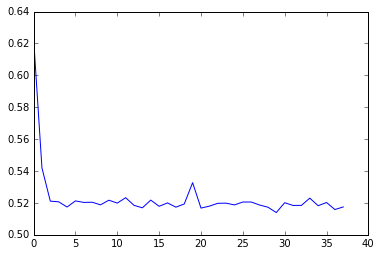

In [17]:
training_losses = train_network(2,num_steps)
plt.plot(training_losses)